## Library Imports

In [ ]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import Counter
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

## Multi Attention Head

In [ ]:
class MultiHead(nn.Module):
  def __init__(self, input_dim, num_heads, mask_flag=False):
    super(MultiHead, self).__init__()
    self.input_dim = input_dim
    self.num_heads = num_heads
    self.head_dim = input_dim // num_heads
    self.mask_flag = mask_flag

    self.q_linear = nn.Linear(input_dim, input_dim)
    self.k_linear = nn.Linear(input_dim, input_dim)
    self.v_linear = nn.Linear(input_dim, input_dim)
    self.out_linear = nn.Linear(input_dim, input_dim)

  def forward(self, query, key=None, value=None):
    # [B, seq_len, input_dim]
    if key is None:
      key = query
    if value is None:
      value = query

    B, seq_q, _ = query.shape
    seq_k = key.shape[1]

    def reshape(x):  # [B, seq_len, input_dim] to [B, num_heads, seq_len, head_dim]
      return x.view(B, -1, self.num_heads, self.head_dim).transpose(1, 2)

    q = reshape(self.q_linear(query))
    k = reshape(self.k_linear(key))
    v = reshape(self.v_linear(value))

    # scaling
    scores = (q @ k.transpose(-2, -1)) / (self.head_dim ** 0.5) # [B, num_heads, seq_q, seq_k]

    if self.mask_flag:
      mask = torch.tril(torch.ones(seq_q, seq_k, device=query.device))
      scores = scores.masked_fill(mask == 0, float('-inf'))

    attn_weights = F.softmax(scores, dim=-1)
    attn_output = attn_weights @ v  # [B, num_heads, seq_q, head_dim]
    attn_output = attn_output.transpose(1, 2).contiguous().view(B, seq_q, self.input_dim)

    return self.out_linear(attn_output)

## Feedforward Network

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, input_dim, hidden_dim):
    super(FeedForward, self).__init__()
    self.fc1 = nn.Linear(input_dim , hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, input_dim)

    self.relu = nn.ReLU()

  def forward(self,x):
    output = self.fc2(self.relu(self.fc1(x)))
    return output

In [ ]:
# class PositionalEncoding(nn.Module):
#   def __init__(self):
#     super(PositionalEncoding, self).__init__()


## Positional Encoding

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, input_dim, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, input_dim)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, input_dim, 2).float() * -(math.log(10000.0) / input_dim))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# Encoder

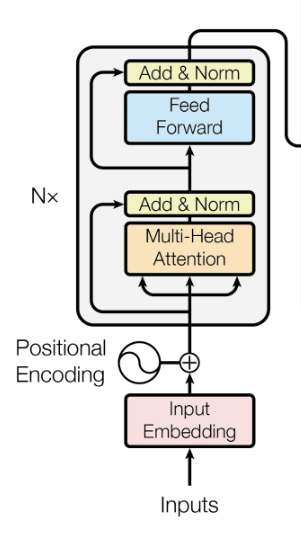

In [ ]:
class EncoderBlock(nn.Module):
  def __init__(self, input_dim, num_heads, hidden_size, dropout):
    super(EncoderBlock,self).__init__()

    self.multi_head = MultiHead(input_dim, num_heads)
    self.feedforward = FeedForward(input_dim, hidden_size)

    self.norm1 = nn.LayerNorm(input_dim)
    self.norm2 = nn.LayerNorm(input_dim)

    self.dropout = nn.Dropout(dropout)

  def forward(self,x):
    x = self.norm1(x + self.dropout(self.multi_head(x)))
    x = self.norm2(x + self.dropout(self.feedforward(x)))
    return x

# Decoder


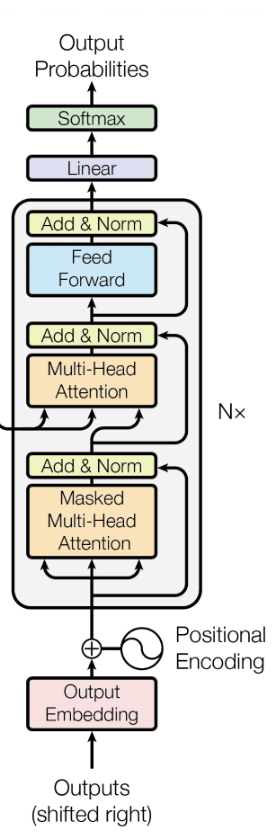

In [ ]:
class DecoderBlock(nn.Module):
  def __init__(self, input_dim, num_heads, hidden_size, dropout, mask_flag=True):
    super(DecoderBlock, self).__init__()
    self.self_attention = MultiHead(input_dim, num_heads, mask_flag)
    self.norm1 = nn.LayerNorm(input_dim)

    self.cross_attention = MultiHead(input_dim, num_heads)
    self.norm2 = nn.LayerNorm(input_dim)

    self.feedforward = FeedForward(input_dim, hidden_size)
    self.norm3 = nn.LayerNorm(input_dim)

    self.dropout = nn.Dropout(dropout)

  def forward(self, x, encoder_out):
    x = self.norm1(x + self.dropout(self.self_attention(x)))
    x = self.norm2(x + self.dropout(self.cross_attention(x, encoder_out, encoder_out)))  # Q=x, K=V=encoder_out
    x = self.norm3(x + self.dropout(self.feedforward(x)))
    return x

# Transformer

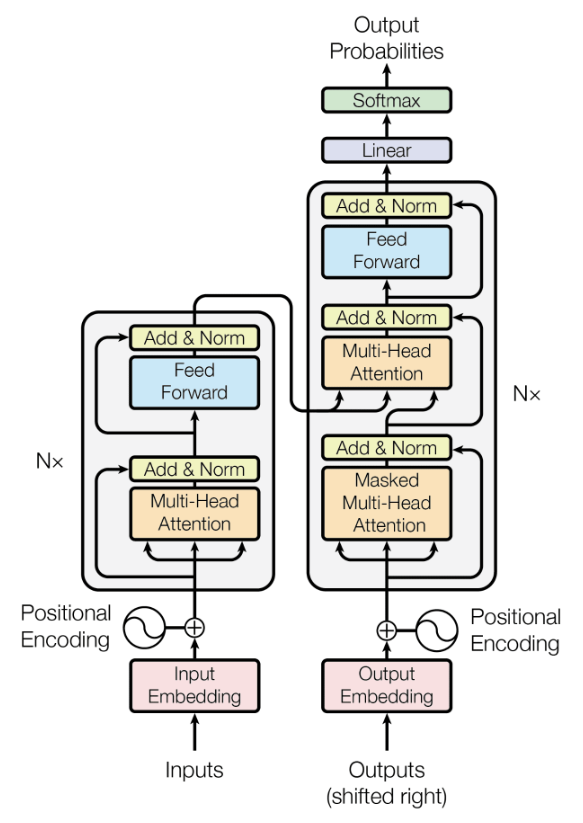

In [ ]:
class Transformer(nn.Module):
  def __init__(self,
               source_vocab_len,
               target_vocab_len,
               max_seq_len,
               emb_dim,
               num_heads,
               num_blocks,
               hidden_size,
               dropout):
    super(Transformer,self).__init__()
    self.encoder_emb = nn.Embedding(source_vocab_len, emb_dim)
    self.decoder_emb = nn.Embedding(target_vocab_len, emb_dim)

    self.pos_encoding = PositionalEncoding(emb_dim, max_seq_len)

    self.encoder_blocks = nn.ModuleList([EncoderBlock(emb_dim, num_heads,hidden_size,dropout) for _ in range(num_blocks)])
    self.decoder_blocks = nn.ModuleList([DecoderBlock(emb_dim, num_heads,hidden_size,dropout,mask_flag = True) for _ in range(num_blocks)])

    self.fc = nn.Linear(emb_dim, target_vocab_len)
    self.dropout = nn.Dropout(dropout)

  def forward(self, src, tgt):
    src_embedded = self.dropout(self.pos_encoding(self.encoder_emb(src)))
    tgt_embedded = self.dropout(self.pos_encoding(self.decoder_emb(tgt)))

    encoder_out = src_embedded
    for encoder_block in self.encoder_blocks:
        encoder_out = encoder_block(encoder_out)

    decoder_out = tgt_embedded
    for decoder_block in self.decoder_blocks:
        decoder_out = decoder_block(decoder_out, encoder_out)

    output = self.fc(decoder_out)
    return output


# Decoder only english text generator

### Model Definition

In [ ]:
# Decoder based text generation model
class DecoderTextGenerator(nn.Module):
  def __init__(self, emb_dim, vocab_size, num_heads,hidden_size, dropout):
    super(DecoderTextGenerator, self).__init__()

    self.embedding = nn.Embedding(vocab_size, emb_dim)
    self.decoder_block = DecoderBlock(emb_dim, num_heads,hidden_size, dropout)
    self.fc = nn.Linear(emb_dim, vocab_size)

  def forward(self, x): # [B, s]
    x = self.embedding(x) # [B, s, emb]
    x = self.decoder_block(x) # [B, s, emb]
    x = self.fc(x) # [B, s, vocab_size]
    return x

## BPE

In [ ]:
class BPETokenizer:
    def __init__(self):
        self.vocab = {0: '<pad>', 1: '<sos>', 2: '<eos>'}
        self.inverse_vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2}
        self.merges = {}

    def train(self, text, vocab_size):
        unique_chars = sorted(set(text))
        vocab_len = len(self.vocab)

        for i, c in enumerate(unique_chars):
            token_id = vocab_len + i
            self.vocab[token_id] = c
            self.inverse_vocab[c] = token_id

        sequence = [self.inverse_vocab[c] for c in text] # tokens

        while len(self.vocab) < vocab_size:
            pair_counts = Counter(zip(sequence, sequence[1:]))
            if not pair_counts:
                break

            best_pair = max(pair_counts.items(), key=lambda x: x[1])[0]
            new_token_id = max(self.vocab) + 1

            merged_str = self.vocab[best_pair[0]] + self.vocab[best_pair[1]]

            self.vocab[new_token_id] = merged_str
            self.merges[best_pair] = new_token_id

            i = 0
            new_seq = []
            while i < len(sequence):
                if i < len(sequence) - 1 and (sequence[i], sequence[i + 1]) == best_pair:
                    new_seq.append(new_token_id)
                    i += 2
                else:
                    new_seq.append(sequence[i])
                    i += 1
            sequence = new_seq

    def encode(self, text, add_special_tokens=True):
        tokens = [self.inverse_vocab.get(c, self.inverse_vocab['<pad>']) for c in text]
        # merge_pairs = list(self.merges.items())
        while True:
            i = 0
            new_tokens = []
            merged = False
            while i < len(tokens):
                if i < len(tokens) - 1 and (tokens[i], tokens[i + 1]) in self.merges:
                    new_tokens.append(self.merges[(tokens[i], tokens[i + 1])])
                    i += 2
                    merged = True
                else:
                    new_tokens.append(tokens[i])
                    i += 1
            tokens = new_tokens
            if not merged:
                break

        if add_special_tokens:
            tokens = [self.inverse_vocab['<sos>']] + tokens + [self.inverse_vocab['<eos>']]
        return tokens

    def decode(self, tokens):
        filtered = [t for t in tokens if t not in {self.inverse_vocab['<sos>'], self.inverse_vocab['<eos>'], self.inverse_vocab['<pad>']}]
        return ''.join(self.vocab.get(t, '') for t in filtered)

In [ ]:
text = "today is a nice day"

tokenizer = BPETokenizer()

tokenizer.train(text, vocab_size = 20)

encodings = tokenizer.encode(text)
print("Encodings ::")
print(encodings)
print('--------------------------------------------------------')
print("Decodings ::")
print(tokenizer.decode(encodings))
print('--------------------------------------------------------')

print("Tokenizer's Vocab")
print(tokenizer.vocab)
print('--------------------------------------------------------')

print("Tokenizer's inverse Vocab")
print(tokenizer.inverse_vocab)
print('--------------------------------------------------------')

print("Merges :: ")
print(tokenizer.merges)
print('--------------------------------------------------------')

Encodings ::
[1, 19, 11, 3, 4, 3, 9, 8, 5, 7, 3, 15, 2]
--------------------------------------------------------
Decodings ::
today is a nice day
--------------------------------------------------------
Tokenizer's Vocab
{0: '<pad>', 1: '<sos>', 2: '<eos>', 3: ' ', 4: 'a', 5: 'c', 6: 'd', 7: 'e', 8: 'i', 9: 'n', 10: 'o', 11: 's', 12: 't', 13: 'y', 14: 'da', 15: 'day', 16: 'to', 17: 'today', 18: 'today ', 19: 'today i'}
--------------------------------------------------------
Tokenizer's inverse Vocab
{'<pad>': 0, '<sos>': 1, '<eos>': 2, ' ': 3, 'a': 4, 'c': 5, 'd': 6, 'e': 7, 'i': 8, 'n': 9, 'o': 10, 's': 11, 't': 12, 'y': 13}
--------------------------------------------------------
Merges :: 
{(6, 4): 14, (14, 13): 15, (12, 10): 16, (16, 15): 17, (17, 3): 18, (18, 8): 19}
--------------------------------------------------------


## Data preparation

In [ ]:
with open('raw_text.txt', 'r', encoding = 'utf-8') as file:
    raw_text = file.read()

In [ ]:
raw_text = raw_text.lower()
print(raw_text)

cats have captivated humans for centuries with their unique personalities, agility, and mysterious aura. whether as beloved pets or independent wanderers, cats have played a significant role in cultures across the world. their distinctive traits, history with humans, and intriguing behaviors make them one of the most fascinating animals on the planet.
the history of cats dates back thousands of years. domesticated cats (felis catus) are believed to have originated from wild feline ancestors in the middle east. ancient egyptians were among the first to embrace cats, depicting them in art and worshipping them as sacred beings. these revered creatures were thought to bring good fortune and protect food supplies by controlling rodent populations. over time, cats spread across different regions, traveling with merchants and explorers, eventually becoming household pets.
despite their domestication, cats have retained many of their natural instincts, making them unique among pets. unlike dog

### Tokenizer test

In [ ]:
encoded = tokenizer.encode(raw_text)

### Data Splitting

In [ ]:
seq_len = 10

X = []
y = []

for i in range(len(encoded) - seq_len):
    X.append(encoded[i:i+seq_len])
    y.append(encoded[i+1:i+seq_len+1])

In [ ]:
X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)

In [ ]:
X.shape, y.shape

(torch.Size([4040, 10]), torch.Size([4040, 10]))

### Dataset and DataLoaders

In [ ]:
dataset = TensorDataset(X,y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
VOCAB_SIZE = 800

### Model, Criterion, Optimizer

In [ ]:
model = DecoderTextGenerator(emb_dim=512, vocab_size=VOCAB_SIZE, num_heads=8 , hidden_size=2048, dropout=0.2)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

### Training Loop

In [ ]:
# Training Loop
num_epochs = 20
vocab_size = VOCAB_SIZE
loss_list = []

for epoch in range(num_epochs):
  for batch_idx, (data, target) in enumerate(dataloader):

    optimizer.zero_grad()

    output = model(data)

    # [B, seq_len, vocab_size]
    # [B, seq_len]
    loss = loss_fn(output.view(-1,vocab_size), target.view(-1))
    loss_list.append(loss.item())

    loss.backward()
    optimizer.step()

  print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

Epoch 1/20, Loss: 3.4828
Epoch 2/20, Loss: 1.9045
Epoch 3/20, Loss: 1.9601
Epoch 4/20, Loss: 1.0863
Epoch 5/20, Loss: 0.8541
Epoch 6/20, Loss: 0.6356
Epoch 7/20, Loss: 0.4932
Epoch 8/20, Loss: 0.3653
Epoch 9/20, Loss: 0.3246
Epoch 10/20, Loss: 0.1610
Epoch 11/20, Loss: 0.1641
Epoch 12/20, Loss: 0.1695
Epoch 13/20, Loss: 0.1769
Epoch 14/20, Loss: 0.2052
Epoch 15/20, Loss: 0.1584
Epoch 16/20, Loss: 0.0973
Epoch 17/20, Loss: 0.0571
Epoch 18/20, Loss: 0.0894
Epoch 19/20, Loss: 0.1859
Epoch 20/20, Loss: 0.0682


Why this fluctuation in losses at certain points ????????????????????????

### Training Plot

Text(0.5, 1.0, 'Training Loss')

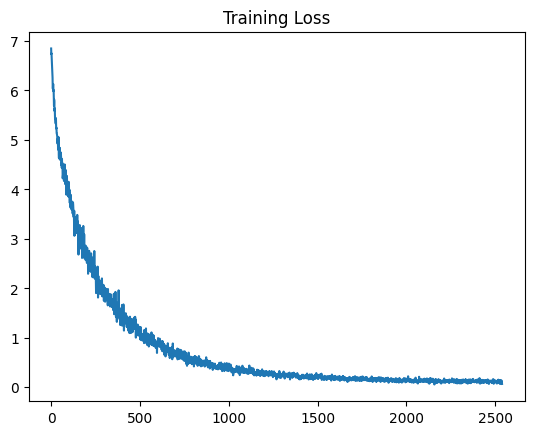

In [ ]:
plt.plot(loss_list)
plt.title("Training Loss")

### Next token prediction model inferencing

In [ ]:
max_len = 20

prompt = "a ginger cat was walking down the "

input_ids = tokenizer.encode(prompt, add_special_tokens=True)[:-1]
print("Input ids :: ",input_ids)
input_tensor = torch.tensor([input_ids], dtype=torch.long)
print("Input tensor :: ",input_tensor)

for _ in range(max_len):
    with torch.no_grad():
        output = model(input_tensor)

    # [B, seq_len, vocab_size]
    next_token_logits = output[0, -1, :]
    next_token_id = torch.multinomial(F.softmax(next_token_logits, dim=-1), num_samples=1).item()

    next_token_id = min(next_token_id, vocab_size - 1)

    if next_token_id == tokenizer.inverse_vocab['<eos>']:
        break

    next_token = torch.tensor([[next_token_id]], dtype=torch.long)
    input_tensor = torch.cat([input_tensor, next_token], dim=1)

Input ids ::  [1, 13, 371, 43, 186, 55, 666, 69, 35, 13, 48, 35, 71, 323, 4, 303, 35, 26, 229]
Input tensor ::  tensor([[  1,  13, 371,  43, 186,  55, 666,  69,  35,  13,  48,  35,  71, 323,
           4, 303,  35,  26, 229]])


In [ ]:
output_tokens = input_tensor[0].tolist()
print(output_tokens)
tokenizer.decode(output_tokens)

[1, 13, 371, 43, 186, 55, 666, 69, 35, 13, 48, 35, 71, 323, 4, 303, 35, 26, 229, 35, 95, 230, 4, 95, 230, 4, 785, 35, 95, 230, 38, 347, 50, 35, 202, 64, 48, 209, 134]


'a ginger cat was walking down the wentpur entpur cats possess a wide range of fascinating traits that set them apart. their agility and flexibility enable them to jump great heights and fit into tight spaces. this is largely due to their strong muscles and highly flexible spine. they also have remarkable reflexes, allowing them to land on their feet in most falls—a phenomenon known as the "cat righting reflex."\none of their most recognizable wentpurzone ofonws are  and s dingay'

# English to Nepali Translation using Transformers

### BPE Tokenizer

In [ ]:
class BPETokenizer:
    def __init__(self):
        self.vocab = {0: '<pad>', 1: '<sos>', 2: '<eos>'}
        self.inverse_vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2}
        self.merges = {}

    def train(self, text, vocab_size):
        unique_chars = sorted(set(text))
        vocab_len = len(self.vocab)

        for i, c in enumerate(unique_chars):
            token_id = vocab_len + i
            self.vocab[token_id] = c
            self.inverse_vocab[c] = token_id

        sequence = [self.inverse_vocab[c] for c in text] # tokens

        while len(self.vocab) < vocab_size:
            pair_counts = Counter(zip(sequence, sequence[1:]))
            if not pair_counts:
                break

            best_pair = max(pair_counts.items(), key=lambda x: x[1])[0]
            new_token_id = max(self.vocab) + 1

            merged_str = self.vocab[best_pair[0]] + self.vocab[best_pair[1]]

            self.vocab[new_token_id] = merged_str
            self.merges[best_pair] = new_token_id

            i = 0
            new_seq = []
            while i < len(sequence):
                if i < len(sequence) - 1 and (sequence[i], sequence[i + 1]) == best_pair:
                    new_seq.append(new_token_id)
                    i += 2
                else:
                    new_seq.append(sequence[i])
                    i += 1
            sequence = new_seq

    def encode(self, text, add_special_tokens=True):
        tokens = [self.inverse_vocab.get(c, self.inverse_vocab['<pad>']) for c in text]
        # merge_pairs = list(self.merges.items())
        while True:
            i = 0
            new_tokens = []
            merged = False
            while i < len(tokens):
                if i < len(tokens) - 1 and (tokens[i], tokens[i + 1]) in self.merges:
                    new_tokens.append(self.merges[(tokens[i], tokens[i + 1])])
                    i += 2
                    merged = True
                else:
                    new_tokens.append(tokens[i])
                    i += 1
            tokens = new_tokens
            if not merged:
                break

        if add_special_tokens:
            tokens = [self.inverse_vocab['<sos>']] + tokens + [self.inverse_vocab['<eos>']]
        return tokens

    def decode(self, tokens):
        filtered = [t for t in tokens if t not in {self.inverse_vocab['<sos>'], self.inverse_vocab['<eos>'], self.inverse_vocab['<pad>']}]
        return ''.join(self.vocab.get(t, '') for t in filtered)

In [ ]:
nep = BPETokenizer()

nep_text = 'घर जग्गा कारोबारमा आत्मविश्वास गुमेको वर्ष बैंकिङ प्रणाली सेयर बजार र घरजग्गाले गएको वर्ष कम्तीमा एउटा साझा समस्या भोगे विश्वासको संकट  साधारणतया ठूलै क्षतिपछि'

nep.train(nep_text, vocab_size = 200)

encodings = nep.encode(nep_text)
print(encodings)
print(nep.decode(encodings))

print(nep.vocab)

[1, 102, 42, 3, 41, 10, 25, 48, 62, 36, 56, 7, 60, 8, 23, 39, 18, 33, 49, 7, 6, 15, 64, 31, 14, 64, 23, 30, 39, 65, 22, 38, 9, 36, 3, 55, 43, 63, 61, 15, 3, 63, 31, 19, 42, 17, 18, 65, 16, 35, 26, 37, 3, 8, 45, 18, 32, 20, 12, 32, 2]
घर जग्गा कारोबारमा आत्मविश्वास गुमेको वर्ष बैंकिङ प्रणाली सेयर बजार र घरजग्गाले गएको वर्ष कम्तीमा एउटा साझा समस्या भोगे विश्वासको संकट  साधारणतया ठूलै क्षतिपछि
{0: '<pad>', 1: '<sos>', 2: '<eos>', 3: ' ', 4: 'ं', 5: 'आ', 6: 'उ', 7: 'ए', 8: 'क', 9: 'ग', 10: 'घ', 11: 'ङ', 12: 'छ', 13: 'ज', 14: 'झ', 15: 'ट', 16: 'ठ', 17: 'ण', 18: 'त', 19: 'ध', 20: 'प', 21: 'ब', 22: 'भ', 23: 'म', 24: 'य', 25: 'र', 26: 'ल', 27: 'व', 28: 'श', 29: 'ष', 30: 'स', 31: 'ा', 32: 'ि', 33: 'ी', 34: 'ु', 35: 'ू', 36: 'े', 37: 'ै', 38: 'ो', 39: '्', 40: 'ा ', 41: 'र ', 42: 'ार', 43: 'को', 44: 'को ', 45: '्ष', 46: 'जग', 47: 'जग्', 48: 'जग्ग', 49: 'मा ', 50: 'वि', 51: 'विश', 52: 'विश्', 53: 'विश्व', 54: 'विश्वा', 55: 'विश्वास', 56: ' ग', 57: 'को व', 58: 'को वर', 59: 'को वर्ष', 60: 'को वर्ष 

### Necessary Imports

In [ ]:
import re
import unicodedata
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

### Data preparation

In [ ]:
df = pd.read_csv('data.csv')

In [ ]:
df.head()

,text,en,np
0,"<s>[INST] Please translate ""It happened after ...","It happened after the death of Saul, when Davi...",दाऊदले अमालेकीहरूलाई हराएर पछि सिकलग गए। यो शा...
1,"<s>[INST] Please translate ""it happened on the...","it happened on the third day, that behold, a m...",तब तेस्रो दिनमा एउटा जवान सैनिक सिकलगमा आयो। त...
2,"<s>[INST] Please translate ""David said to him,...","David said to him, ""Where do you come from?"" H...","दाऊदले त्यसलाई सोधे, “तिमी कहाँबाट आयौ?” त्यस ..."
3,"<s>[INST] Please translate ""David said to him,...","David said to him, ""How did it go? Please tell...","दाऊदले भने, “मलाई भन, के भयो?” त्यसले भन्यो, “..."
4,"<s>[INST] Please translate ""David said to the ...","David said to the young man who told him, ""How...","दाऊदले त्यस सैनिकलाई भने, “तिमीले कसरी जान्यौ ..."


In [ ]:
df = df.drop(columns = ['text'])

In [ ]:
df.head()

,en,np
0,"It happened after the death of Saul, when Davi...",दाऊदले अमालेकीहरूलाई हराएर पछि सिकलग गए। यो शा...
1,"it happened on the third day, that behold, a m...",तब तेस्रो दिनमा एउटा जवान सैनिक सिकलगमा आयो। त...
2,"David said to him, ""Where do you come from?"" H...","दाऊदले त्यसलाई सोधे, “तिमी कहाँबाट आयौ?” त्यस ..."
3,"David said to him, ""How did it go? Please tell...","दाऊदले भने, “मलाई भन, के भयो?” त्यसले भन्यो, “..."
4,"David said to the young man who told him, ""How...","दाऊदले त्यस सैनिकलाई भने, “तिमीले कसरी जान्यौ ..."


In [ ]:
def clean_text(text, lang):
  text.strip()

  if lang == 'en':
    text = text.lower()
    text = re.sub(r"([.!?])", r" \1", text)
    text = re.sub(r"[^a-z!?]+", r" ", text)

  text = unicodedata.normalize("NFC", text)
  text = re.sub(r"\s+", " ", text)
  return text

In [ ]:
df['en'] = df['en'].apply(clean_text, lang='en')
df['np'] = df['np'].apply(clean_text, lang = 'np')

In [ ]:
df.head()

,en,np
0,it happened after the death of saul when david...,दाऊदले अमालेकीहरूलाई हराएर पछि सिकलग गए। यो शा...
1,it happened on the third day that behold a man...,तब तेस्रो दिनमा एउटा जवान सैनिक सिकलगमा आयो। त...
2,david said to him where do you come from ? he ...,"दाऊदले त्यसलाई सोधे, “तिमी कहाँबाट आयौ?” त्यस ..."
3,david said to him how did it go ? please tell ...,"दाऊदले भने, “मलाई भन, के भयो?” त्यसले भन्यो, “..."
4,david said to the young man who told him how d...,"दाऊदले त्यस सैनिकलाई भने, “तिमीले कसरी जान्यौ ..."


In [ ]:
nepali_text = df['np']
english_text = df['en']

# nepali_text.to_csv('nepali_data.txt', index = False)
# english_text.to_csv('english_data.txt', index = False)

# from google.colab import files
# files.download('nepali_data.txt')
# files.download('english_data.txt')

In [ ]:
english = '\n'.join(english_text)
# print(english)
print(len(english))


nepali = '\n'.join(nepali_text)
# print(nepali)
print(len(nepali))

1176997
1327585


In [ ]:
# english_tokenizer = BPETokenizer()
# english_tokenizer.train(english, vocab_size = 4000)

# nepali_tokenizer = BPETokenizer()
# nepali_tokenizer.train(nepali, vocab_size = 4000)

# # Saving the trained tokenizers
# with open('english_tokenizer.pkl', 'wb') as f:
#     pickle.dump(english_tokenizer, f)

# with open('nepali_tokenizer.pkl', 'wb') as f:
#     pickle.dump(nepali_tokenizer, f)

### Loading the pre-trained tokenizers

In [ ]:
english_tokenizer = pickle.load(open('english_tokenizer.pkl', 'rb'))
nepali_tokenizer = pickle.load(open('nepali_tokenizer.pkl', 'rb'))

In [ ]:
len(english_tokenizer.vocab), len(nepali_tokenizer.vocab)

(4000, 4000)

In [ ]:
# from google.colab import files

# files.download('english_tokenizer.pkl')
# files.download('nepali_tokenizer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Data splitting

In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print(train_df.head())

                                                     en  \
9254  these are the children of dishon hemdan eshban...   
1561  he said why would you want go to him today ? i...   
1670  the king said to hazael take a present in your...   
6087  who may ascend to yahweh s hill ? who may stan...   
6669  trust in him at all times you people pour out ...   

                                                     np  
9254  6दीशोनका चार छोराहरू हेमदान, एश्बान, यित्रान र...  
1561  आइमाईको लोग्नेले भन्यो, “तिमी किन आज परमेश्वरक...  
1670  तब राजा बेनहददले हजाएललाई भने, “एउटा उपहार लिन...  
6087  परमप्रभुको पर्वतमाथि को जान सक्छ? उठेर परमप्रभ...  
6669  हे मानिसहरू! परमेश्वरमाथि सधैं भरोसा राख! तिमी...  


In [ ]:
def encode_pair(en_sentence, np_sentence, max_len=50):
    en_tokens = english_tokenizer.encode(en_sentence)
    np_tokens = nepali_tokenizer.encode(np_sentence)

    # Padding
    en_tokens = en_tokens[:max_len] + [0] * (max_len - len(en_tokens))
    np_tokens = np_tokens[:max_len] + [0] * (max_len - len(np_tokens))

    return torch.tensor(en_tokens), torch.tensor(np_tokens)

In [ ]:
class TranslationDataset(Dataset):
    def __init__(self, df, max_len=50):
        self.data = [encode_pair(row['en'], row['np'], max_len) for idx, row in df.iterrows()]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src, tgt = self.data[idx]
        return src, tgt

### Dataset and Dataloaders

In [ ]:
train_dataset = TranslationDataset(train_df)
val_dataset = TranslationDataset(val_df)
test_dataset = TranslationDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Model definition and Training

In [ ]:
model = Transformer(
    source_vocab_len=len(english_tokenizer.vocab),
    target_vocab_len=len(nepali_tokenizer.vocab),
    max_seq_len=136,
    emb_dim=512,
    num_heads=8,
    num_blocks=6,
    hidden_size=2048,
    dropout=0.1
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

#-----------------------------------------------------------------------------
# Training
#-----------------------------------------------------------------------------
num_epochs = 50
loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    running_loss = 0.0
    running_val_loss = 0.0
    model.train()

    for src, tgt in train_loader:
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()
        output = model(src, tgt[:, :-1])
        loss = criterion(output.reshape(-1, output.shape[-1]), tgt[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_list.append(running_loss/len(train_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

    model.eval()
    for src, tgt in val_loader:
        src, tgt = src.to(device), tgt.to(device)
        output = model(src, tgt[:, :-1])
        loss = criterion(output.reshape(-1, output.shape[-1]), tgt[:, 1:].reshape(-1))
        running_val_loss += loss.item()

    val_loss_list.append(running_val_loss/len(val_loader))
    print(f"Validation Loss: {running_val_loss/len(val_loader)}")
    print('--------------------------------------------------------------------------------')

Epoch 1/50, Loss: 4.918310258865357
Validation Loss: 4.014774188399315
--------------------------------------------------------------------------------
Epoch 2/50, Loss: 3.7629525146484375
Validation Loss: 3.560046821832657
--------------------------------------------------------------------------------
Epoch 3/50, Loss: 3.3915314540863037
Validation Loss: 3.3250378221273422
--------------------------------------------------------------------------------
Epoch 4/50, Loss: 3.1452362928390505
Validation Loss: 3.1552408188581467
--------------------------------------------------------------------------------
Epoch 5/50, Loss: 2.9556185789108276
Validation Loss: 3.0279577746987343
--------------------------------------------------------------------------------
Epoch 6/50, Loss: 2.7878431091308595
Validation Loss: 2.935376524925232
--------------------------------------------------------------------------------
Epoch 7/50, Loss: 2.630102576255798
Validation Loss: 2.853651873767376
---------

KeyboardInterrupt: 

### Training Plots

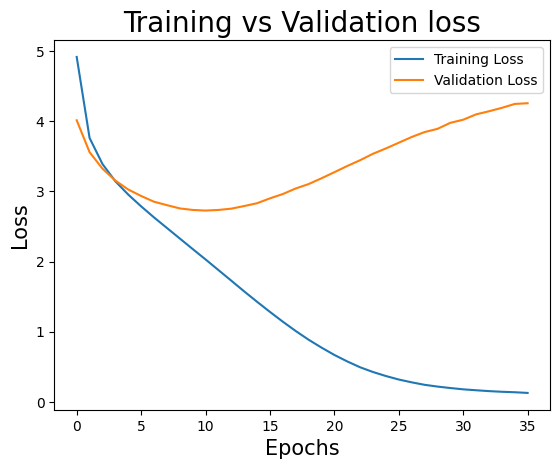

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_list, label = 'Training Loss')
plt.plot(val_loss_list, label = 'Validation Loss')
plt.title("Training vs Validation loss", fontsize = 20)
plt.xlabel("Epochs", fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.legend()
plt.show()

### Inference

In [ ]:
def decode(model, src_sentence, max_len=50, device='cpu'):
    model.eval()

    src_tokens = english_tokenizer.encode(src_sentence)
    src_tokens = src_tokens[:max_len] + [0] * (max_len - len(src_tokens))
    src_tensor = torch.tensor(src_tokens).unsqueeze(0).to(device)

    tgt_tokens = [nepali_tokenizer.inverse_vocab['<sos>']]
    tgt_tensor = torch.tensor(tgt_tokens).unsqueeze(0).to(device)

    for _ in range(max_len):
        tgt_padded = tgt_tensor
        if tgt_tensor.size(1) < max_len:
            pad_len = max_len - tgt_tensor.size(1)
            tgt_padded = F.pad(tgt_tensor, (0, pad_len), value=0)

        with torch.no_grad():
            output = model(src_tensor, tgt_padded)

        next_token_logits = output[0, tgt_tensor.size(1) - 1]
        next_token = torch.multinomial(F.softmax(next_token_logits, dim=-1), num_samples=1).item()


        tgt_tokens.append(next_token)

        if next_token == nepali_tokenizer.inverse_vocab['<eos>']:
            break

        tgt_tensor = torch.tensor(tgt_tokens).unsqueeze(0).to(device)

    return nepali_tokenizer.decode(tgt_tokens)

In [ ]:
translated_text = decode(model, " How are the mighty fallen in the midst of the battle! Jonathan is slain on your high places.", device='cuda')
print("Translated Nepali:", translated_text)

Translated Nepali: जङ्गली गधाहरू बलियाह, जसरी एकजना मानिस अत्यन्त विशालहरूलाई जित्नुहोस्। अनि तिनीहरूले उनुहोस्।


In [ ]:
translated_text = decode(model, "Today is a really nice day and I love it", device='cuda')
print("Translated Nepali:", translated_text)

Translated Nepali: तब परमेश्वरले मानिसलाई गाड्नु भयो जुन धार्मिक मानिसहरूलाई पनि बँयौ।


In [ ]:
translated_text = decode(model, "My name is prash", device='cuda')
print("Translated Nepali:", translated_text)

Translated Nepali: प्रत्येक जातिमाथि, म शिक्षा दिभने!
